# Split the data into training and test sets

In [2]:
import pandas as pd
import matplotlib
from matplotlib import pyplot
from sklearn.model_selection import train_test_split

## Load metadata

In [3]:
sample_metadata = pd.read_csv("../data/merged_metadata.tsv", sep="\t", index_col=0)
sample_metadata

,Age,Gender,Status,TotalNumReads,NumUniquelyMappedReads,UniquelyMappedReadsPercentage
SampleID,,,,,,
C1,34.44,Female,C-R,"7,293,272","6,044,825",82.88%
C2,43.35,Female,C-R,"7,870,895","6,526,361",82.92%
C3,43.85,Female,C-R,"6,622,312","5,620,525",84.87%
C4,41.42,Female,C-R,"8,248,171","7,041,599",85.37%
C5,42.12,Female,C-R,"9,233,397","7,922,603",85.80%
...,...,...,...,...,...,...
N28,29.00,Female,N,"8,579,794","7,286,744",84.93%
N29,32.00,Female,N,"10,808,607","8,789,442",81.32%
N30,41.00,Female,N,"7,312,205","5,604,035",76.64%


## Split the metadata based on the `Status` column

There are three possible `Status` values: `C-R` (cancer sample - recurrent), `C-N` (cancer sample - nonrecurrent), and `N` (non-cancer sample). Let's split up samples from each of these three categories into training and test, so that we have six groups total.

In [4]:
status_vals = sorted(list(sample_metadata["Status"].unique()))
print(f"The {len(status_vals)} unique statuses are {', '.join(status_vals)}.")

The 3 unique statuses are C-N, C-R, N.


### Sidenote: How many samples are there from each group?

C-N    68
N      32
C-R    28
Name: Status, dtype: int64 Index(['C-N', 'N', 'C-R'], dtype='object')
x ['C-N', 'C-R', 'N']
y [68, 28, 32]


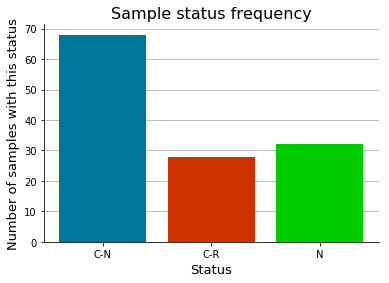

In [5]:
val_counts = sample_metadata["Status"].value_counts()
print(val_counts, val_counts.index)
x = status_vals
y = [val_counts[s] for s in x]

print("x", x)
print("y", y)

fig, ax = pyplot.subplots(1)
ax.bar(x, y, color=["#007799", "#cc3300", "#00cc00"], zorder=100)
ax.set_xlabel("Status", fontsize=13)
ax.set_ylabel("Number of samples with this status", fontsize=13)
ax.set_title("Sample status frequency", fontsize=16)

# Draw a horizontal grid, but behind the bars: to do this we use distinct zorders.
# From https://stackoverflow.com/a/23358722.
ax.grid(axis="y", zorder=0)

# To make the plot look prettier (?) hide the top and right lines. From https://stackoverflow.com/a/28720127.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.savefig("../figs/sample_status_freq.png", bbox_inches="tight")

As we can see, we've got many more `C-N` samples than `C-R` or `N` samples.

### Actually split up the dataset

We'll create a new `TrainTest` column and export a "final" sample metadata file that includes this column.

In [6]:
sample_metadata["TrainTest"] = ""
for s in status_vals:
    samples_with_status = sample_metadata.loc[sample_metadata["Status"] == s]
    
    # We use the default split amounts provided by train_test_split: 25% test, 75% training. Since the
    # numbers of samples we have in each status group are all divisible by 4, this works out nicely.
    #
    # Use of train_test_split() and a random state for consistency's sake suggested by
    # https://machinelearningmastery.com/train-test-split-for-evaluating-machine-learning-algorithms/.
    training_samples, test_samples = train_test_split(samples_with_status.index, random_state=333)
    
    # Iteration is sorta inefficient in pandas, but since this DF only has 128 rows it really doesn't matter
    for sample in training_samples:
        sample_metadata.loc[sample, "TrainTest"] = "Training"
    for sample in test_samples:
        sample_metadata.loc[sample, "TrainTest"] = "Test"
    
    print((
        f"For status {s}, which has {val_counts[s]} samples, there are "
        f"{len(test_samples)} / {val_counts[s]} ({100 * len(test_samples) / val_counts[s]:.1f}%) "
        "test samples and "
        f"{len(training_samples)} / {val_counts[s]} ({100 * len(training_samples) / val_counts[s]:.1f}%) "
        "training samples."
    ))
sample_metadata.to_csv("../data/final_metadata.tsv", sep="\t")

For status C-N, which has 68 samples, there are 17 / 68 (25.0%) test samples and 51 / 68 (75.0%) training samples.
For status C-R, which has 28 samples, there are 7 / 28 (25.0%) test samples and 21 / 28 (75.0%) training samples.
For status N, which has 32 samples, there are 8 / 32 (25.0%) test samples and 24 / 32 (75.0%) training samples.
